In [1]:
from test_hmmbatchcd import *
from test_hmmbatchsgd import *

#define epsilon for test_hmmbatchsgd likelihood convergence
epsilon=10**(-8)

/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/multinomial.py:21: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')
/run/media/davovapo/hdd1-dvp/DSMMaster/tesis/variational-inf-for-HSMM/pybasicbayes/distributions/negativebinomial.py:25: UserWarning: using slow sample_crp_tablecounts
  warn('using slow sample_crp_tablecounts')


[2.28428957 3.18361902]
Hamming Distance =  0.37666666666666665


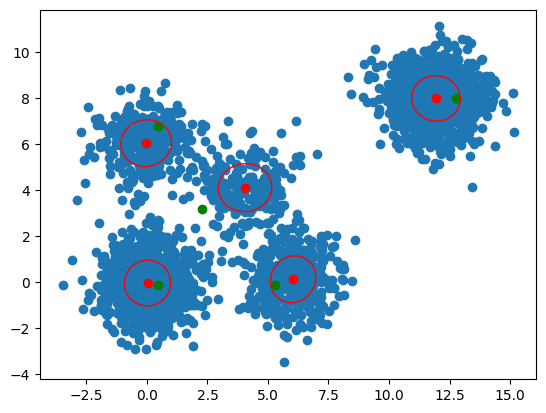

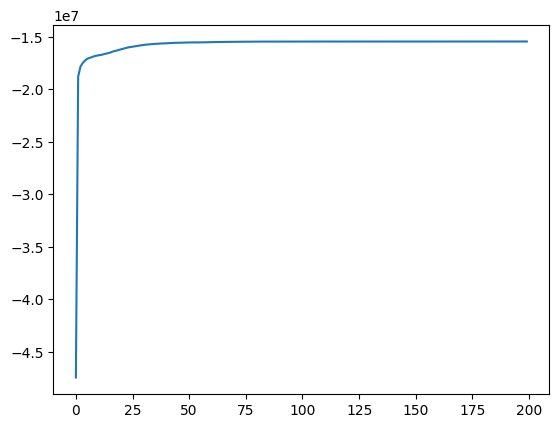

In [2]:
test_hmmbatchsgd(maxit=200, epsilon=epsilon, batch_size=256)

[3.47002712 2.98508716]
Hamming Distance =  0.317


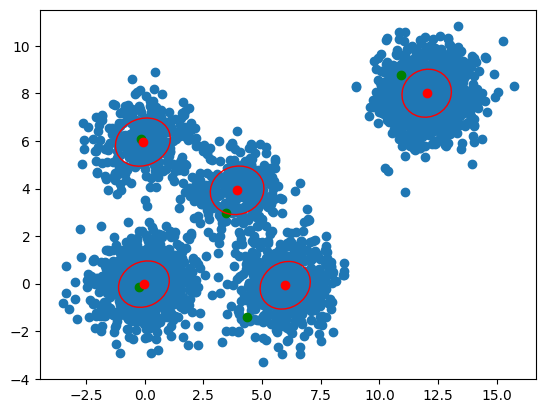

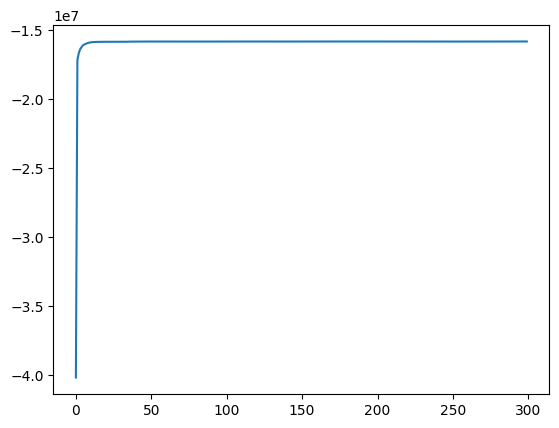

In [7]:
#batch 700 - 300 it
test_hmmbatchsgd(maxit=300, epsilon=epsilon, batch_size=700)

[10.08781362  8.79037302]
Hamming Distance =  0.37366666666666665


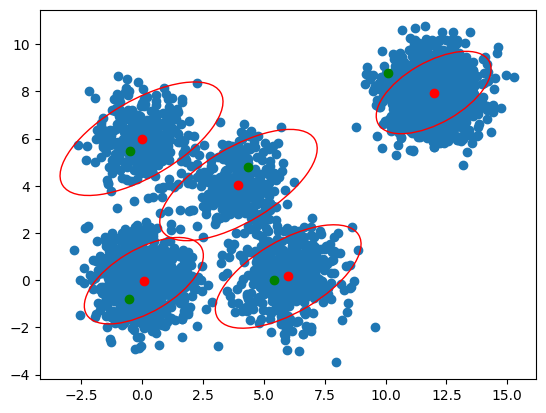

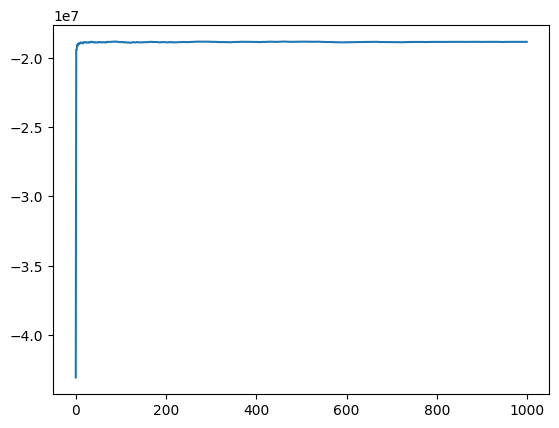

In [8]:
#batch 10 - 1000 it

test_hmmbatchsgd(maxit=1000, epsilon=epsilon, batch_size=10)

[10.90148735  7.52304667]
Hamming Distance =  0.388


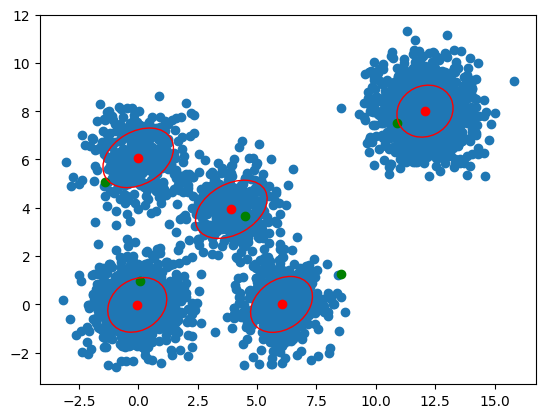

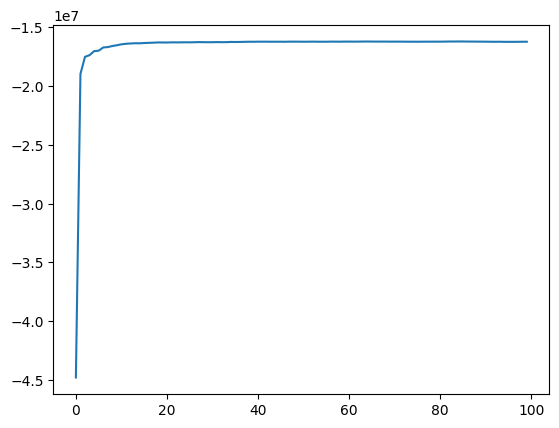

In [17]:
#batch 150 - 100 it
test_hmmbatchsgd(maxit=100, epsilon=epsilon, batch_size=150)

In [15]:
#in case we want to see the elbo

# code from test_hmmbatchcd
import numpy as np
import matplotlib.pyplot as plt
import util
import hmmbatchsgd as HMM

from scipy.spatial.distance import hamming as hd
from pybasicbayes.distributions import Gaussian
from util import *

#make test_hmmbatchsgd return the elbo

#elbo=test_hmmbatchsgd()

#plt.plot(elbo)

#elbo

## Runtime comparison: sgd vs all observations

[5.3246699  4.58577876]
Hamming Distance =  0.323


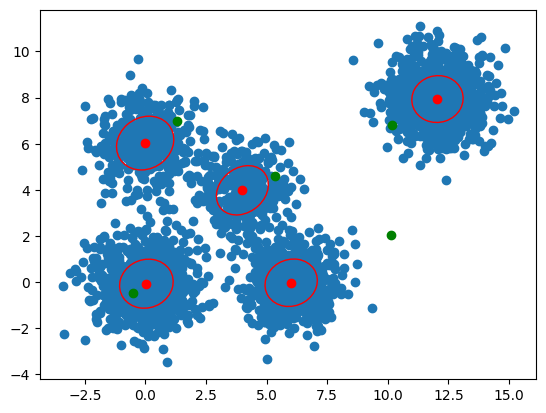

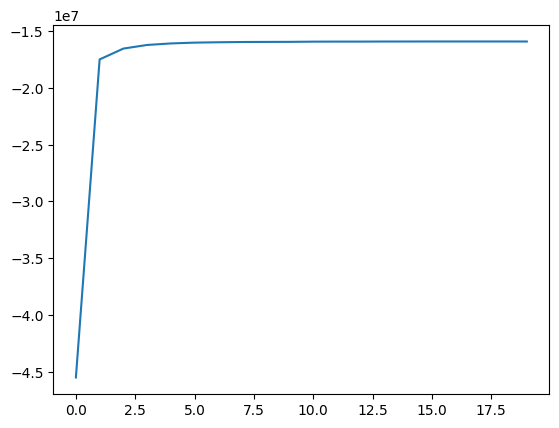

True
terminated early - convergence, 
 elbo : -15301002.253334187 
 lower bound : -15301002.253334187
allclose  = True, diff : 0.0
[3.66128616 3.67718389]
Hamming Distance =  0.3446666666666667


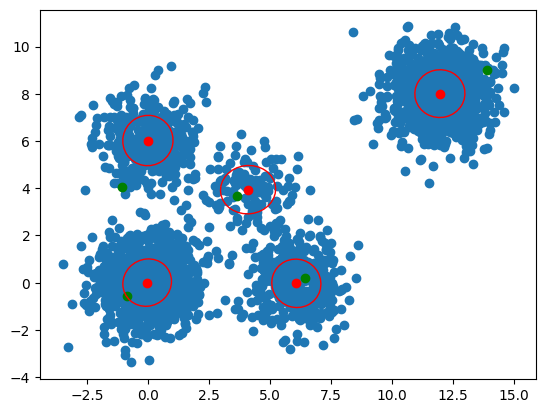

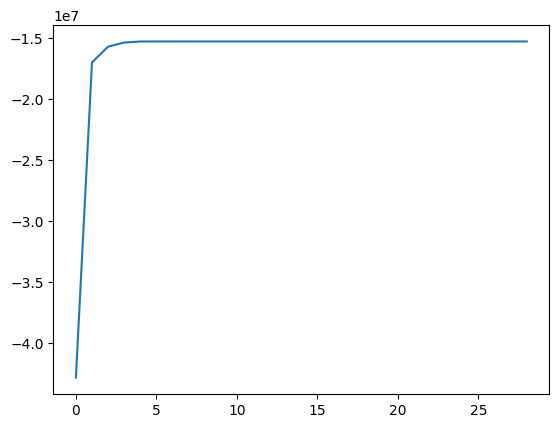

test_hmmbatchsgd() took 1.54 seconds to run
test_hmmbatchcd() took 2.15 seconds to run


In [16]:
#20 maxit 500 batch
from test_hmmbatchcd import *
from test_hmmbatchsgd import *
import time

# time the execution of test_hmmbatchsgd()
start_time = time.time()
test_hmmbatchsgd(maxit=20, epsilon=epsilon, batch_size=500)
end_time = time.time()
elapsed_time_sgd = end_time - start_time

# time the execution of test_hmmbatchcd()
start_time = time.time()
test_hmmbatchcd()
end_time = time.time()
elapsed_time_cd = end_time - start_time

print("test_hmmbatchsgd() took {:.2f} seconds to run".format(elapsed_time_sgd))

print("test_hmmbatchcd() took {:.2f} seconds to run".format(elapsed_time_cd))

In [ ]:
# add distribution plot comparison with 
#  MCMC, VI full dataset, good approx SVI with enough batch_size, bad approx SVI with small batch_size

# add 1 or 2 plots of zoomed elbo

# add plot of hmm distance vs batch_size
